In [1]:
from DIG import DIG
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
import matplotlib.pyplot as plt

2024-06-15 11:34:54.117951: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 11:34:54.123841: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 11:34:54.227861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 11:34:56.277441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preparing the Data for tests -- DIG


 

#### Ideas: 
1. We currently force that each point can only have one anchor (because we assume its a one to one correspondonce). However, what if we removed that limitation? Would it be better? My supporting thought for this, is if the algorithm is fairly confident that two points are anchors, they are very similar, and so the algorithm would benefit from thinking them as anchors anyways; even though we know one of the points are wrong
    - > Test setting it to the value instead as of an anchor
2. Sometimes, our hold_out_anchor scores a remarkably high distance from each other. We can maybe set a thing that if no anchors are within the threshold, we can make that hold_out_anchor actually an anchor -- my guess is that it will have the greatest effect on the alignment.

### Questions:
1. How does the second max affect things? (Should it be kept at 1, or found somehow?)

In [2]:
#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="seeds.csv", split = "random", percent_of_anchors= [0.2], verbose = 2, random_state= 10)


 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

Splitting the data randomly
Split A features shape: (199, 5)
Split B Features shape (199, 2)
MDS initialized with 2 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [3]:
perfect = DIG(dc.split_A, dc.split_B, dc.anchors, t = -1, knn = 1, link = "None", verbose = 2, merge = False, density_normalization = False)

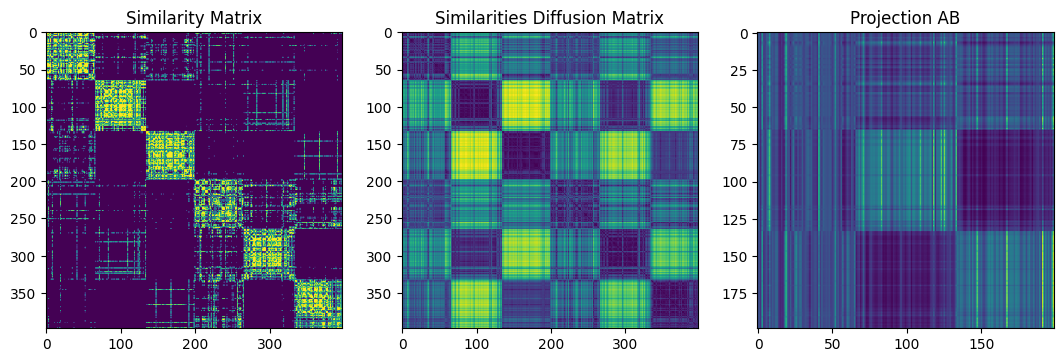

In [4]:
perfect.plot_graphs()

Model Stress: 3.486428976888378
Cross Embedding: 0.8190954773869347
FOSCTTM: 0.16527360420191406


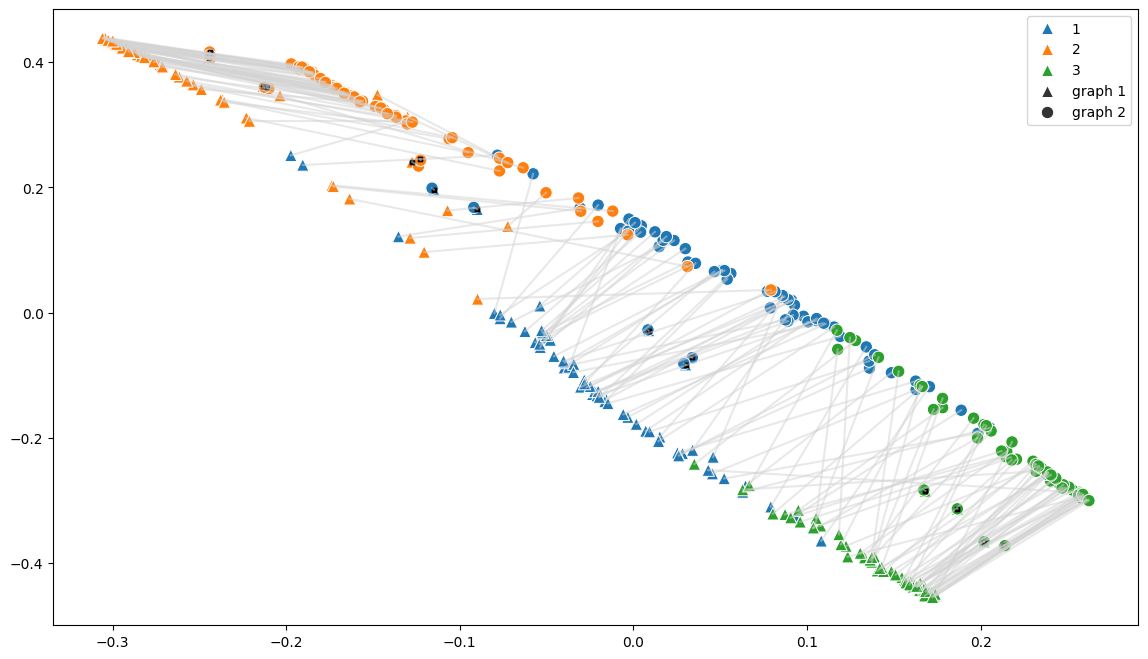

In [5]:
perfect.plot_emb(labels = dc.labels_doubled)

# Finding close connections alignment 


This algorithm does the following things:
1. It seeks to find the points that have the least distance to each other (and hopefully they are the same point)
2. It then saves those connection values, and uses them in the future to when rebuilding the graph connections ... (It doesn't save them to known anchors though, but a different variable list)
3. It thens tests the new alignment (If we use labels, we can also compare CE):
    1. If the scores are better, it keeps the alignment. 
    2. if the Scores are worse, it prunes those values and throws out the alignment? (Do we want to add a weight between those values?)
4. Then it repeats the process for a certain amount of epochs or until the algorithm no longer improves
    


In [9]:
def _find_new_connections(self, pruned_connections = [], connection_limit = None, threshold = 0.2): 
    """A helper function that finds and returns a list of possible anchors and their associated wieghts after alignment.
        
    Parameters:
        :connection_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        :pruned_connections: should be a list formated like Known Anchors. The node connections in this list will not be considered
            for possible connections. 
        
    returns possible anchors plus known anchors in a single list"""

    #Keep Track of known-connections 
    known_connections = self.similarity_matrix > 0 #Creates a mask of everywhere we have a connection

    if self.verbose > 0:
        print(f"Total number of Known_connections: {np.sum(known_connections)}")

    #Set our Known-connections to inf values so they are not found and changed
    array = np.array(self.sim_diffusion_matrix) #This is made into an array to ensure we aren't passing by reference
    array[known_connections] = np.inf

    #Modify our array just to be the off-diagonal 
    array = array[:self.len_A, self.len_A:]

    #Add in our pruned connections
    array[pruned_connections] = np.inf

    #Set anchor limit to 1/3 of the unknown data points
    if connection_limit == None:
        #connection_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
        connection_limit = int(array.shape[0] * array.shape[1])

    """ This section actually finds and then curates potential anchors """

    
    # Flatten the array
    array_flat = array.flatten()

    # Get the indices that would sort the array
    smallest_indices = np.argsort(array_flat)

    # Select the indices of the first 5 smallest values
    smallest_indices = smallest_indices[:connection_limit]

    # Convert the flattened indices to tuple coordinates (row, column)
    coordinates = [np.unravel_index(index, array.shape) for index in smallest_indices]

    #Add in coordinate values as the third index in the tuple
    coordinates = [(int(coordinate[0]), int(coordinate[1]), array[coordinate[0], coordinate[1]]) for coordinate in coordinates]

    #Apply the Threshold
    from itertools import takewhile
    coordinates = np.array(list(takewhile(lambda x: x[2] < threshold, coordinates)))

    return coordinates

## Testing the algorithm with many epochs

Idea! Instead of using Hold-out anchors, what if we instead set the threshold based on the distribution of data from the first Epoch?

Reasoning: 
- If we do this, if their are values within them they will work. 
- The values shift from epoch to epoch, so there will be different "learned" connections


Observations:
- Threshold around 0.1 is a good spot usually, although it varies. 
- None for a connection limit always does well, but 1/5 or 1x or 10x of data points beat it out (but took significantly longer). It seems the less the better the CE, but longer time it will take


Best choice
- None : 1
- 1/5 : 2
- 10x : 2
- 1x: 1

In [8]:
def optimize_by_creating_connections(self, epochs = 3, threshold = "auto", connection_limit = "auto", hold_out_anchors = []):
    """Finds potential anchors after alignment, and then recalculates the entire alignment with the new anchor points for each epoch. 
    
    Parameters:
        :connection_limit: should be an integer. If set, it will cap out the max amount of anchors found. 
            Best values to try: 1/5 of the length of data, 1/10 length of the data, 10x length of data, or None. 
        :threshold: should be a float. If auto, the algorithm will determine it. It can not be higher than the median of the dataset.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        :pruned_connections: should be a list formated like Known Anchors. The node connections in this list will not be considered
            for possible connections. 
        :epochs: the number of iterations the cycle will go through. 
    """

    #Create a list to return diffusion matrices NOTE: we can delete this later, simply for my testing sanity
    dif_list = []

    #Show the original connections
    if self.verbose > 1:
        print("<><><><><> Beggining Tests. Original Connections show below <><><><><>")
        plt.imshow(self.similarity_matrix)
        plt.show()

    
    #Set pruned_connections to equal hold_out_anchhor connections if they exist, empty otherwise
    if len(hold_out_anchors) > 0:
        #Firt add the anchor connections (We do this first to A, as it will later be added to pruned anchors. This helps us later when adding the known values in at the end)
        pruned_connections = list(hold_out_anchors)

        hold_neighbors_A = []
        hold_neighbors_B = []

        #Add in the the connections of each neighbor to each anchor
        for anchor_pair in hold_out_anchors: #TODO: Vectorize this somehow?

            #Cache the data
            hold_neighbors_A += [(neighbor, anchor_pair[1]) for neighbor in set(self.graph_a.to_igraph().neighbors(anchor_pair[0], mode="out"))]
            hold_neighbors_B += [(anchor_pair[0], neighbor) for neighbor in set(self.graph_b.to_igraph().neighbors(anchor_pair[1], mode="out"))]

            #Add the connections
            pruned_connections += hold_neighbors_A
            pruned_connections += hold_neighbors_B
        
        #Convert to Numpy array for advanced indexing
        hold_neighbors_A = np.array(hold_neighbors_A)
        hold_neighbors_B = np.array(hold_neighbors_B)
        
    else:
        pruned_connections = []

    if threshold == "auto":
        #Set the threshold to be the 10% limit of the connections
        threshold = np.sort(self.sim_diffusion_matrix.flatten())[:int(len(self.sim_diffusion_matrix.flatten()) * .1)][-1]

    if connection_limit == "auto":
        #Set the connection limit to be 10x the shape (just because its usualy good and fast)
        connection_limit = 10 * self.len_A

    #Create an empty Numpy array
    pruned_connections = np.array([]).astype(int)

    #Get the current score of the alignment
    current_score = np.mean([self.partial_FOSCTTM(self.sim_diffusion_matrix[self.len_A:, :self.len_A], hold_out_anchors), self.partial_FOSCTTM(self.sim_diffusion_matrix[:self.len_A, self.len_A:], hold_out_anchors)])

    #Find the Max value for new connections to be set too
    second_max = np.median(self.similarity_matrix[self.similarity_matrix != 0])
    
    if self.verbose > 0:
        print(f"Second max: {second_max}")
    
    #Rebuild Class for each epoch
    for epoch in range(0, epochs):
        
        if self.verbose > 0:
            print(f"<><><><><><><><><><><><>    Starting Epoch {epoch}    <><><><><><><><><><><><><>")

        #Find predicted anchors
        new_connections = _find_new_connections(self, pruned_connections, threshold = threshold, connection_limit = connection_limit)

        if len(new_connections) < 1:
            print("No new_connections. Exiting process")

            #Add in the known anchors and reset the known_anchors and other init variables
            if len(hold_out_anchors) > 0:
                #Cached info 
                adjusted_hold_neighbors_B = hold_neighbors_B + self.len_A

                #Set the anchors
                self.similarity_matrix[hold_out_anchors[:, 0], hold_out_anchors[:, 1] + self.len_A] = 1
                self.similarity_matrix[hold_out_anchors[:, 0] + self.len_A, hold_out_anchors[:, 1]] = 1

                #Set the other connections (taking values from the top left)
                self.similarity_matrix[hold_neighbors_A[:, 0], hold_neighbors_A[:, 1] + self.len_A] = self.similarity_matrix[hold_neighbors_A[:, 0], hold_neighbors_A[:, 1]]
                self.similarity_matrix[hold_neighbors_A[:, 0] + self.len_A, hold_neighbors_A[:, 1]] = self.similarity_matrix[hold_neighbors_A[:, 0], hold_neighbors_A[:, 1]]

                #Take connection values from the bottom right 
                self.similarity_matrix[hold_neighbors_B[:, 0], adjusted_hold_neighbors_B[:, 1]] = self.similarity_matrix[adjusted_hold_neighbors_B[:, 0], adjusted_hold_neighbors_B[:, 1]]
                self.similarity_matrix[adjusted_hold_neighbors_B[:, 0], hold_neighbors_B[:, 1]] = self.similarity_matrix[adjusted_hold_neighbors_B[:, 0], adjusted_hold_neighbors_B[:, 1]]

                #Get Diffusion Matrix
                self.sim_diffusion_matrix, self.projectionAB, self.projectionBA = self.get_diffusion(self.similarity_matrix, self.t, link = self.link)
            

            #Return false to signify we didn't go through all the tests
            return dif_list

        #Continue to show connections
        print(f"New connections found: {len(new_connections)}")

        #Copy Similarity matrix
        new_similarity_matrix = np.array(self.similarity_matrix) #We do this redudant conversion to ensure we aren't copying over a reference

        #Add the new connections
        new_similarity_matrix[new_connections[:, 0].astype(int), (new_connections[:, 1] + self.len_A).astype(int)] = second_max - new_connections[:, 2] #The max_value minus is supposed to help go from distance to similarities
        new_similarity_matrix[(new_connections[:, 0] + self.len_A).astype(int) , new_connections[:, 1].astype(int)] = second_max - new_connections[:, 2] #This is so we get the connections in the other off-diagonal block

        #Show the new connections
        if self.verbose > 1:
            plt.imshow(new_similarity_matrix)
            plt.show()
        
        #Get new Diffusion Matrix
        new_sim_diffusion_matrix, new_projectionAB, new_projectionBA = self.get_diffusion(new_similarity_matrix, self.t, link = self.link)

        #Get the new score
        new_score = np.mean([self.partial_FOSCTTM(new_sim_diffusion_matrix[self.len_A:, :self.len_A], hold_out_anchors), self.partial_FOSCTTM(new_sim_diffusion_matrix[:self.len_A, self.len_A:], hold_out_anchors)])

        #See if the extra connections helped
        if new_score < current_score or len(hold_out_anchors) < 1:
            print(f"The new connections improved the alignment by {current_score - new_score}\n-----------     Keeping the new alignment. Continuing...    -----------\n")
            
            #Add it to diff_lists
            dif_list.append(new_sim_diffusion_matrix)

            #Reset all the class variables
            self.similarity_matrix = new_similarity_matrix
            self.sim_diffusion_matrix = new_sim_diffusion_matrix
            self.projectionAB = new_projectionAB
            self.projectionBA = new_projectionBA

            #Reset the score
            current_score = new_score

        else:
            print(f"The new connections worsened the alignment by {new_score - current_score}\n-----------     Pruning the new connections. Continuing...    -----------\n")

            #Add the added connections to the the pruned_connections
            if len(pruned_connections) < 1:
                pruned_connections = new_connections[:, :2].astype(int)
            else:
                pruned_connections = np.concatenate([pruned_connections, new_connections[:, :2]]).astype(int)

    #On the final epoch, we can evaluate with the hold_out_anchors and then assign them as anchors. 
    if epoch == epochs - 1 and len(hold_out_anchors) > 0:
        #Cached info 
        adjusted_hold_neighbors_B = hold_neighbors_B + self.len_A

        #Set the anchors
        self.similarity_matrix[hold_out_anchors[:, 0], hold_out_anchors[:, 1] + self.len_A] = 1
        self.similarity_matrix[hold_out_anchors[:, 0] + self.len_A, hold_out_anchors[:, 1]] = 1

        #Set the other connections (taking values from the top left)
        self.similarity_matrix[hold_neighbors_A[:, 0], hold_neighbors_A[:, 1] + self.len_A] = self.similarity_matrix[hold_neighbors_A[:, 0], hold_neighbors_A[:, 1]]
        self.similarity_matrix[hold_neighbors_A[:, 0] + self.len_A, hold_neighbors_A[:, 1]] = self.similarity_matrix[hold_neighbors_A[:, 0], hold_neighbors_A[:, 1]]

        #Take connection values from the bottom right 
        self.similarity_matrix[hold_neighbors_B[:, 0], adjusted_hold_neighbors_B[:, 1]] = self.similarity_matrix[adjusted_hold_neighbors_B[:, 0], adjusted_hold_neighbors_B[:, 1]]
        self.similarity_matrix[adjusted_hold_neighbors_B[:, 0], hold_neighbors_B[:, 1]] = self.similarity_matrix[adjusted_hold_neighbors_B[:, 0], adjusted_hold_neighbors_B[:, 1]]

        #Recalculate diffusion matrix
        self.sim_diffusion_matrix, self.projectionAB, self.projectionBA = self.get_diffusion(self.similarity_matrix, self.t, link = self.link)

        #Show the final connections
        if self.verbose > 1:
            print("Added Hold Out Anchor Conections")
            plt.imshow(self.similarity_matrix)
            plt.show()
        
    #Process Finished
    print("<><><><><><><><><><<><><><><<> Epochs Finished <><><><><><><><><><><><><><><><><>")
    return dif_list

In [126]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:8], t = -1, knn = 4, link = "None", verbose = 1, density_normalization = False)

results = optimize_by_creating_connections(test, epochs = 1000, connection_limit = "auto", threshold = "auto", hold_out_anchors=dc.anchors[:16]) #10x .51 nd 0.26, 1/5, 1

Second max: 0.5
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 2342
New connections found: 1255
The new connections worsened the alignment by 0.041666666666666685
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 2342
No new_connections. Exiting process


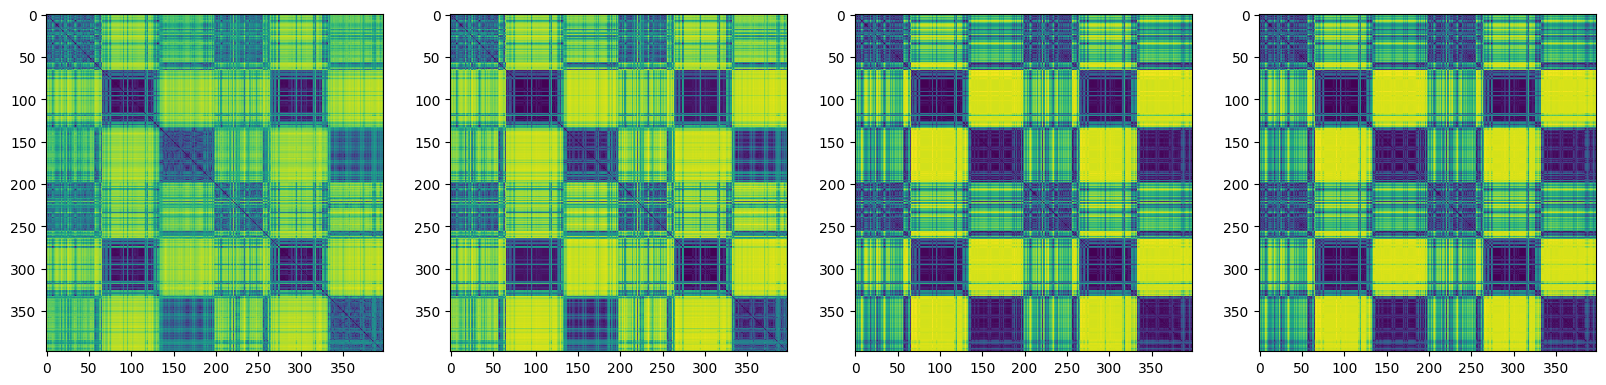

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
try:
    axs[0].imshow(results[0])
    axs[1].imshow(results[1])
    axs[2].imshow(results[-2])
    axs[3].imshow(results[-1])
except:
    print("Not enough passed epochs")

(<matplotlib.image.AxesImage at 0x7f984c72d8a0>, 1.0, 0.0)

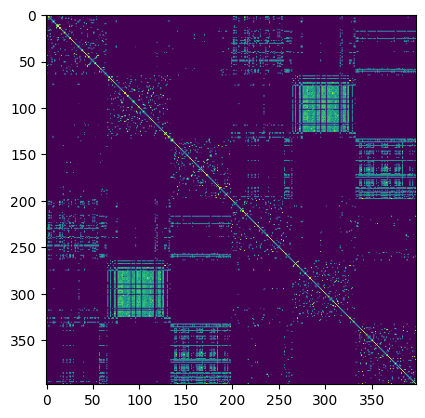

In [10]:
plt.imshow(test.similarity_matrix), np.max(test.similarity_matrix), np.min(test.similarity_matrix)

(<matplotlib.image.AxesImage at 0x7f984c7a4250>, 1.0, 0.0)

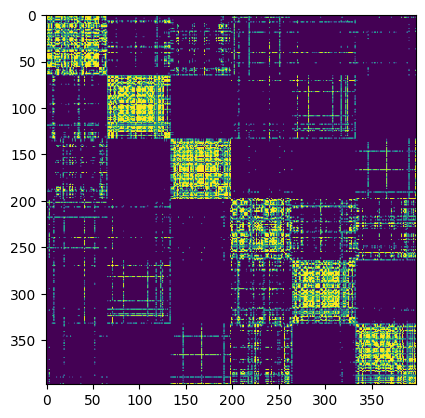

In [11]:
plt.imshow(test1.similarity_matrix), np.max(test1.similarity_matrix), np.min(test1.similarity_matrix)

Model Stress: 5.531353702069204
Cross Embedding: 0.8844221105527639
FOSCTTM: 0.05951869902275195


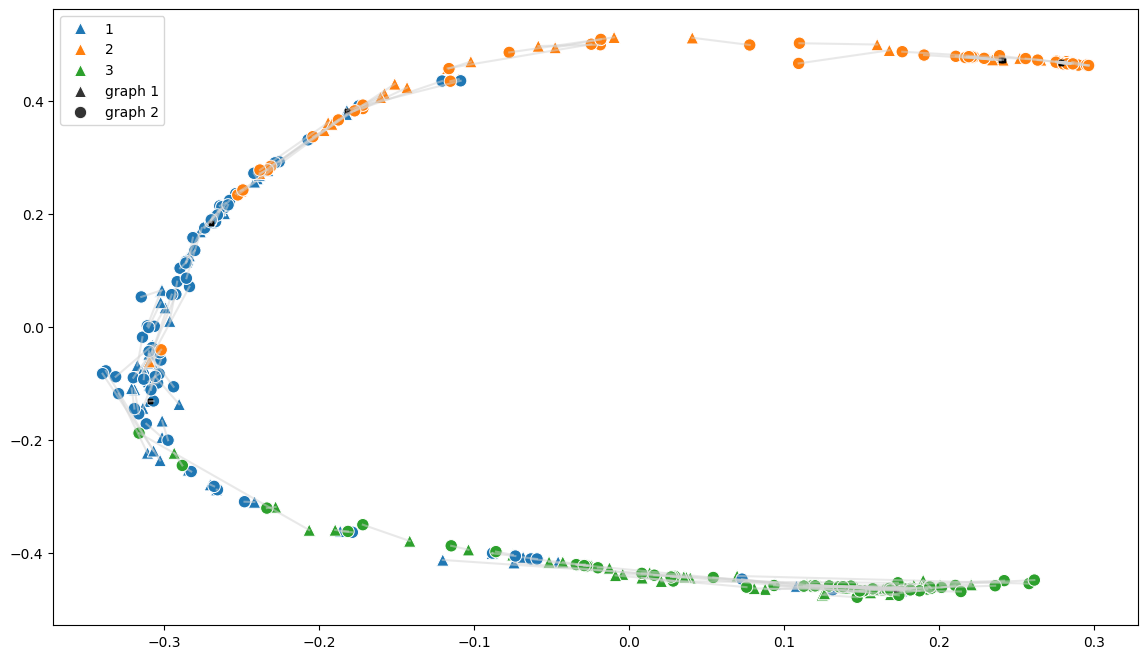

In [12]:
test.plot_emb(labels = dc.labels_doubled)

Model Stress: 3.486428976888378
Cross Embedding: 0.8190954773869347
FOSCTTM: 0.16527360420191406


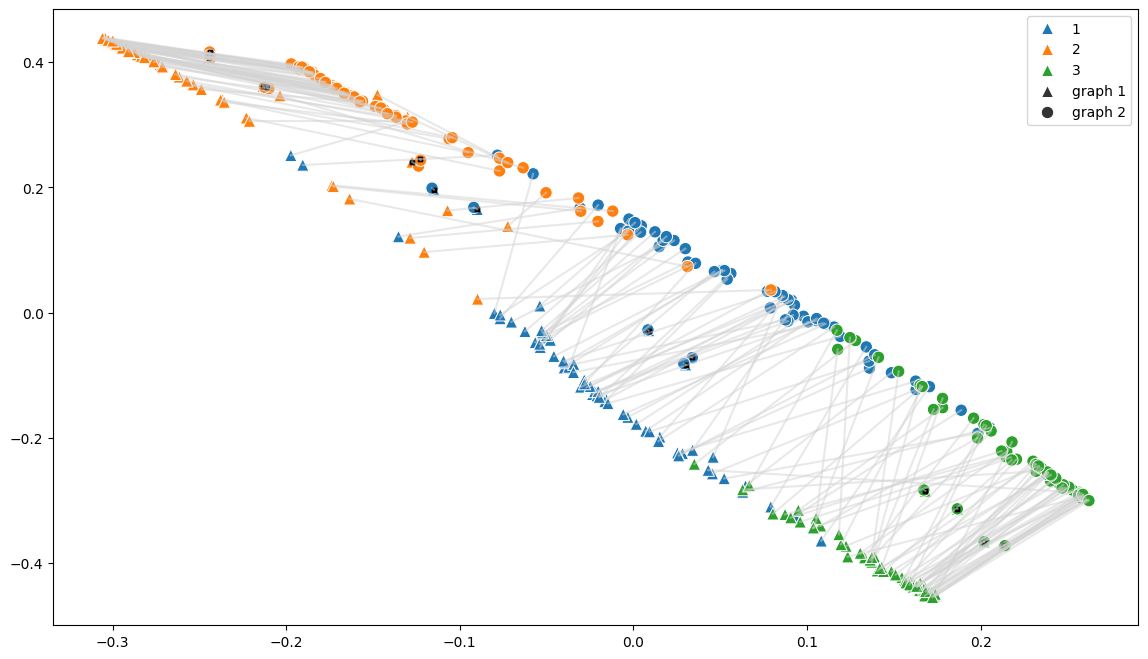

In [13]:
#Compare to original 
test1.plot_emb(labels = dc.labels_doubled)

Iris Results --- Without Pruning
1. Major sucess! With many epochs, and many connections, it did very well on distort split (improving CE metric 0.4 and FOSCTTM by 0.5)
2. With an even split, the CE was improved by 0.4, and FOSTTCM was slightly worse
3. Did slightly better on Random splits
4. MAJOR SUCESS with turn. Practically made FOSCTTM 0, and CE was slightly better
5. Great success with skewed. Upped CE by 3%, and lowered FOSCTTM by 2%

Iris Results with Pruning
1. Similar with Skewed
2. EVEN: Both metrics improved by 0.2
3. Huge success with Random splits, improving each metric by nearly 5%
4. TURN: slightly worse CE, but huge improvements on FOSCTTM (about 5%)
5. DISTORT: Marginally better across both Metrics. 

Tests reducing "Second_max"
1. TURN: Very helpful: improved CE by 2%
2. Not Helpful with Skewed
3. Controversial: Reduced Fosctm by 10% but lowed CE by 4%
4. Helpful for EVEN


Hyper-parameters adjustments
1. It seems that it helps to form as much connections as possible. Connection_limit seems to be best when set to None
2. The Threshold Seems to do great at 10% of the data (or a little less)


<Axes: >

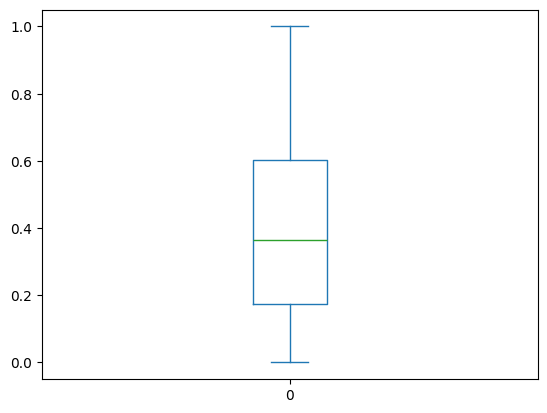

In [14]:
#Viewing the distribution
all_points  = pd.DataFrame(test1.sim_diffusion_matrix.flatten())
all_points.plot(kind = "box")

In [15]:
all_points.describe()

0
count  158404.000000
mean        0.402382
std         0.263951
min         0.000000
25%         0.175528
50%         0.363974
75%         0.601555
max         1.000000

In [16]:
#Find what percent of data is below 0.2
np.sum(all_points < 0.17) / len(all_points)

0    0.236408
dtype: float64

In [17]:
#Find what value 10% of the values are under
value = int(len(all_points) * .1)

np.sort(test1.sim_diffusion_matrix.flatten())[:value][-1]

0.08026284452970758

# Density Normalization Tests

Iris Test Logs:
1. Iris on Even -- preformed slightly worse
2. Iris on Distort -- Performed much worse, but then slightly better with improved connections
3. Iris on Random -- Preformed slightly worse

Seeds Test Logs:
1. Random: preformed significantly worse
2. Distort: preformed slightly worse
3. Skewed: preformed slightly worse, but then significantly better with the new connections (this is likely because it ran more tests... less connections per epoch might be helpful)
4. Even: preformed slightly worse

Hepatitis: 
1. Even: Preformed significantly better
2. Skewed: Preformed Signifcantly better
3. Random: Preformed Similarly
4. Distort: Preformed Slightly Worse

Glass:
1. Distort: Preformed Slightly Worse
2, Even: Preformed worse, then better
3. Random: Similar

Cancer Data:
Random: Slightly worse

In [181]:
#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="Cancer_Data.csv", split = "skewed", percent_of_anchors= [0.3], verbose = 2)


 
 
---------------------------       Initalizing class with Cancer_Data.csv data       ---------------------------

Splitting the data in a skewed fashion
Split A features shape: (569, 15)
Split B Features shape (569, 15)
MDS initialized with 15 components
The knn values are: (2, 14, 26, 38, 50, 62, 74, 86, 98, 110)


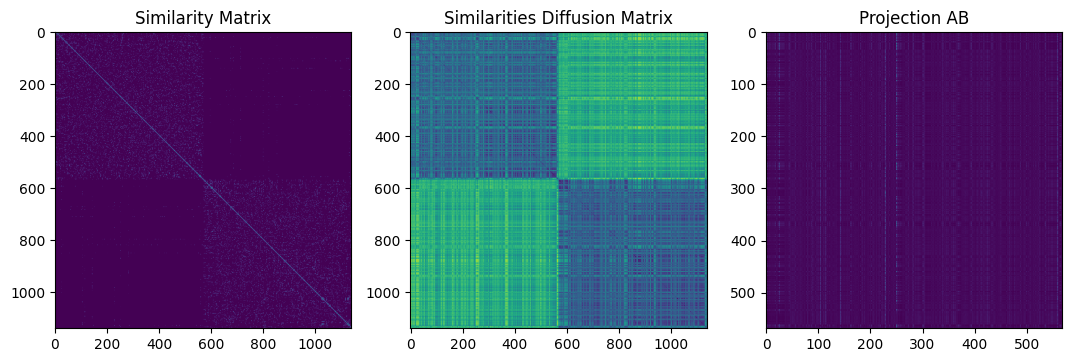

In [182]:
no_norm = DIG(dc.split_A, dc.split_B, dc.anchors[:8], t = -1, knn = 12, link = "None", verbose = 2, density_normalization = False)
no_norm.plot_graphs()

Model Stress: 521.0226925554375
Cross Embedding: 0.8892794376098418
FOSCTTM: 0.3148526227680295


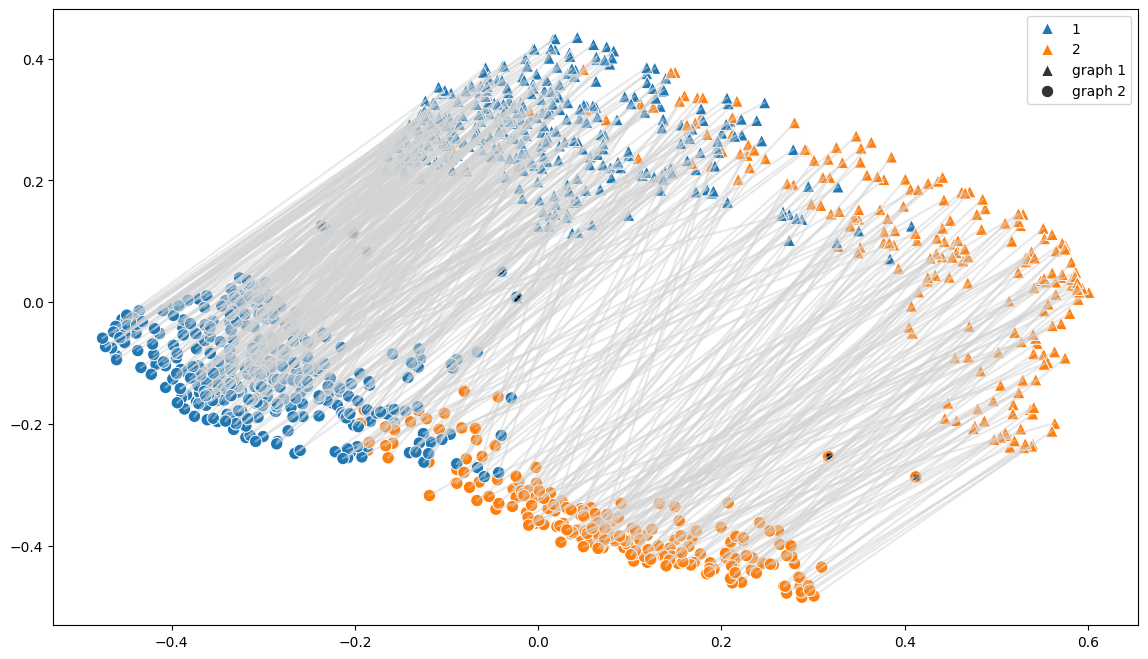

In [183]:
no_norm.plot_emb(labels = dc.labels_doubled, n_comp = 2)

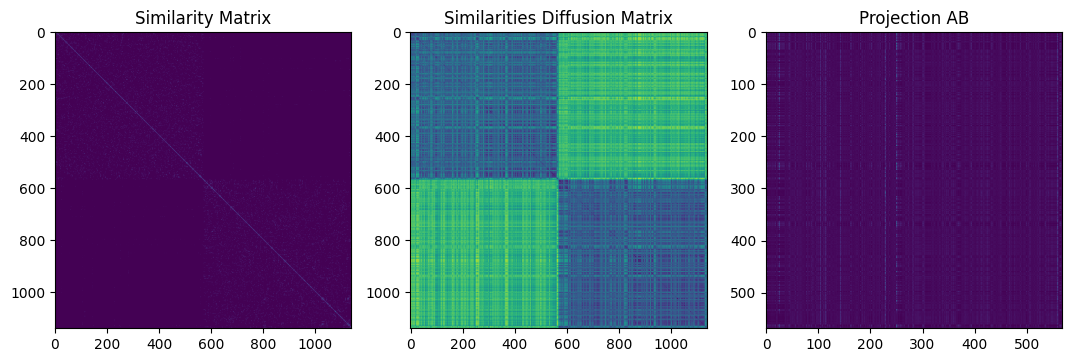

In [184]:
normed = DIG(dc.split_A, dc.split_B, dc.anchors[:8], t = -1, knn = 12, link = "None", verbose = 2, density_normalization = True)
normed.plot_graphs()

Model Stress: 680.0634296855792
Cross Embedding: 0.8734622144112478
FOSCTTM: 0.3298358974675764


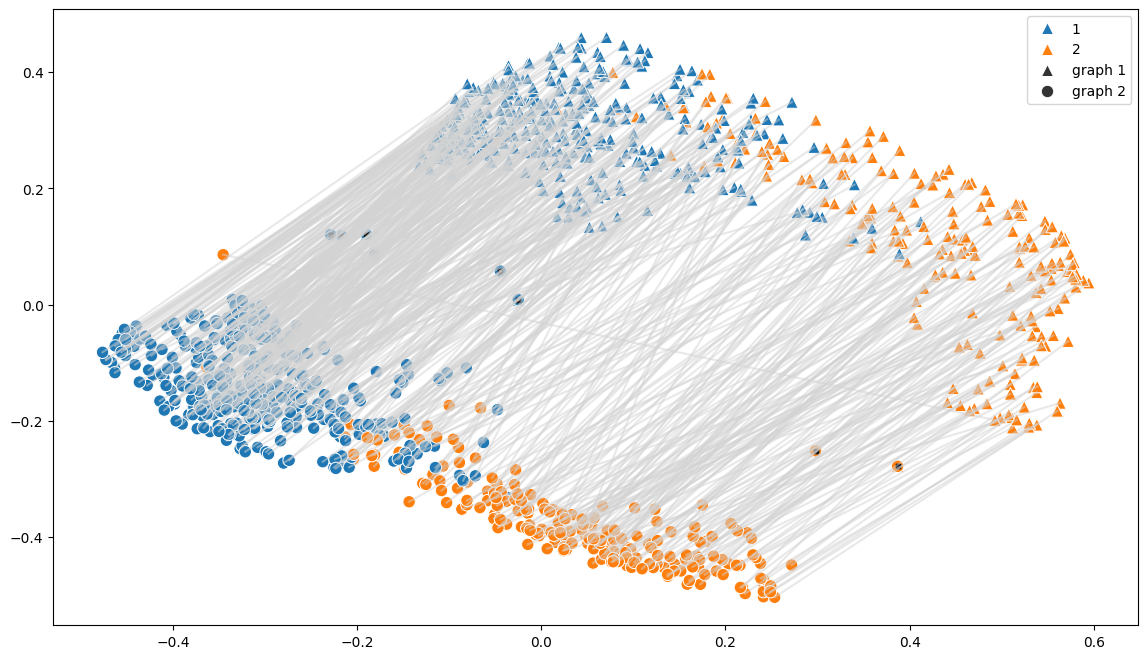

In [185]:
normed.plot_emb(labels = dc.labels_doubled, n_comp = 2)

<><><><><> Beggining Tests. Original Connections show below <><><><><>


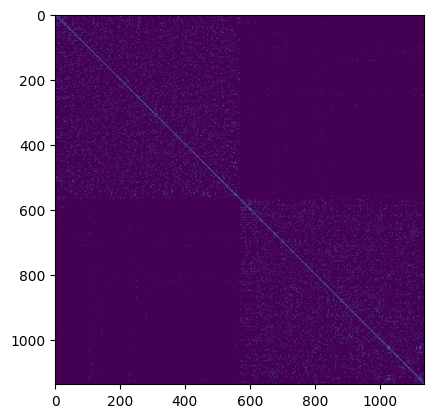

Second max: 0.4981986035905589
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 21458
New connections found: 23


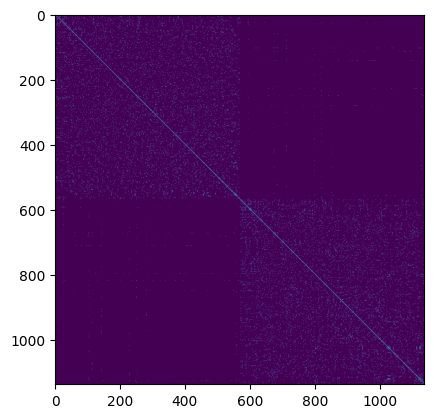

The new connections worsened the alignment by 0.0016476274165202476
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 21458
No new_connections. Exiting process


In [186]:
results = optimize_by_creating_connections(no_norm, epochs = 1000, connection_limit = "auto", threshold = "auto", hold_out_anchors=dc.anchors[8:16]) #10x .51 nd 0.26, 1/5, 1

<><><><><> Beggining Tests. Original Connections show below <><><><><>


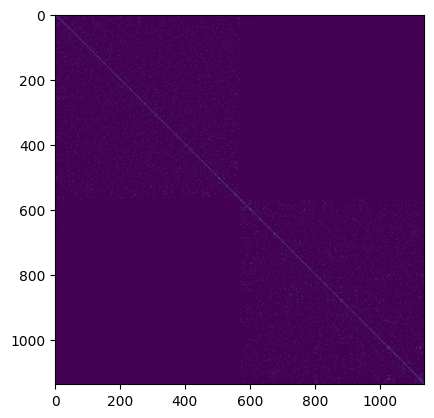

Second max: 0.25108832716698426
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 21458
New connections found: 14


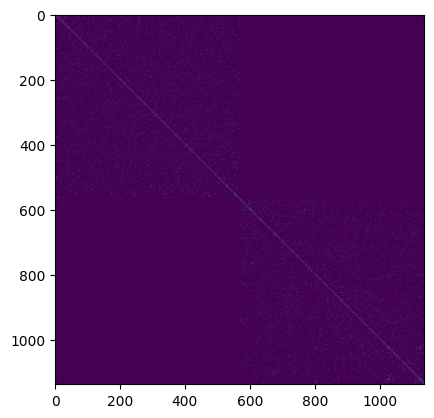

The new connections improved the alignment by 0.0001098418277679647
-----------     Keeping the new alignment. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 21486
No new_connections. Exiting process


In [187]:
results = optimize_by_creating_connections(normed, epochs = 1000, connection_limit = "auto", threshold = "auto", hold_out_anchors=dc.anchors[8:16]) #10x .51 nd 0.26, 1/5, 1

Model Stress: 857.9852109919855
Cross Embedding: 0.9349736379613357
FOSCTTM: 0.22476147528578178


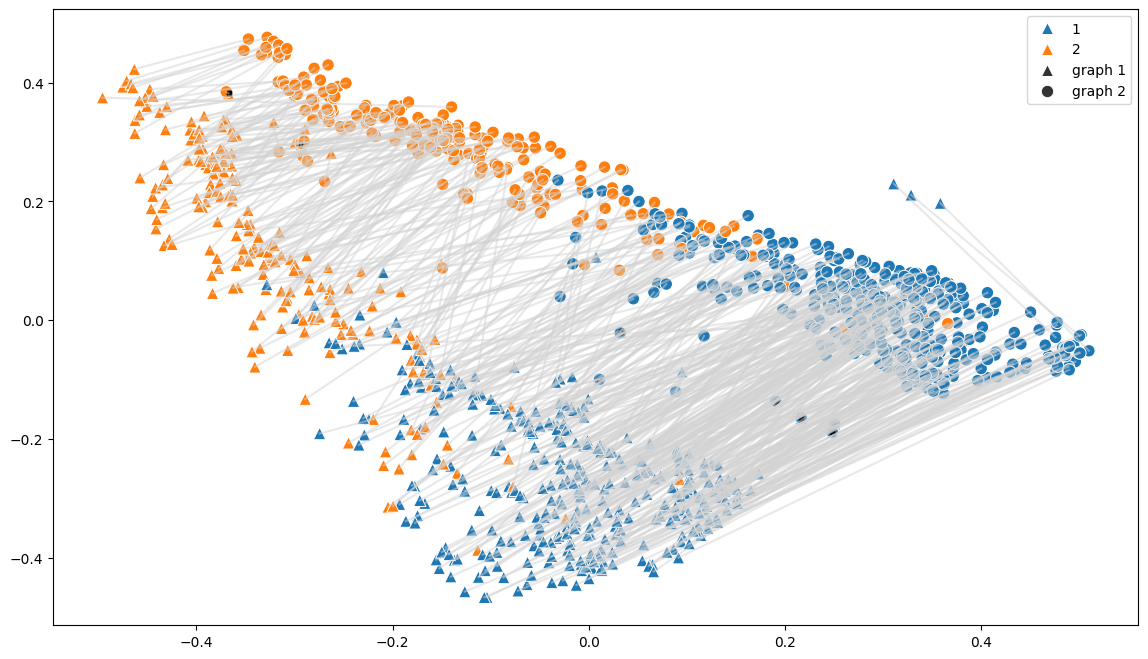

In [188]:
no_norm.plot_emb(labels = dc.labels_doubled, n_comp = 2)

Model Stress: 915.0286747708286
Cross Embedding: 0.9261862917398945
FOSCTTM: 0.24395155685829983


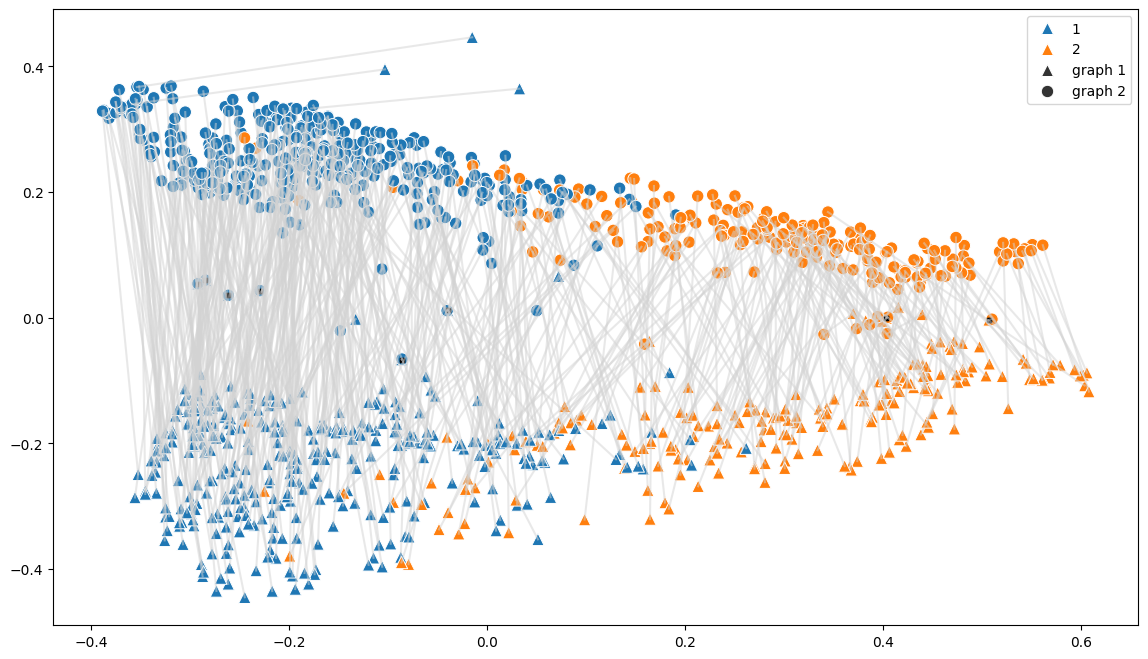

In [189]:
normed.plot_emb(labels = dc.labels_doubled, n_comp = 2)

# Testing with SPUD

In [152]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors3(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    len_A = self.graphA.vcount()
    array = self.block[:len_A, len_A:]

    #Set anchor limit to 1/3 of the unknown data points
    if anchor_limit == None:
        anchor_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = array[hold_out_anchors[0][0], hold_out_anchors[0][1]]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.median(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?

    """ This section actually finds and then curates potential anchors """
    
    #Alert of chosen Threshold
    print(f"Threshold: {threshold}\n\n")


    #Set the current known anchors to be np.NaN so they aren't calculated, but keep their index
    array[self.known_anchors[:, 0], :] = np.NaN
    array[:, self.known_anchors[:, 1]] = np.NaN

    hold_out_anchors =np.array(hold_out_anchors)
    array[hold_out_anchors[:, 0], :] = np.NaN
    array[:, hold_out_anchors[:, 1]] = np.NaN
    
    # Flatten the array and get the sorted indices
    flat_array = array.flatten()
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Create a cost matrix using the top (num_pairs * num_pairs) smallest elements
    selected_coords = coordinates[:anchor_limit * anchor_limit]
    num_elements = len(selected_coords)
    
    # Construct the reduced cost matrix
    cost_matrix = np.full((num_elements, num_elements), np.nanmax(array)*10)
    
    for i, (row_i, col_i) in enumerate(selected_coords):
        for j, (row_j, col_j) in enumerate(selected_coords):
            if row_i != row_j and col_i != col_j:
                cost_matrix[i, j] = array[row_j, col_j]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, and used_cols
    used_rows = set()
    used_cols = set()
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Check to see if it is below the threshold
            if array[row, col] < threshold:

                #Add the data
                min_pairs.append((row, col))
                used_rows.add(row)
                used_cols.add(col)

                #Break once we hit our limit
                if len(min_pairs) >= anchor_limit:
                    break
    
    return min_pairs, array


In [153]:
from SPUD import SPUD
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs",  knn = 5, kind = "pure", show = True)

TypeError: SPUD.__init__() got an unexpected keyword argument 'kind'

In [ ]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

In [ ]:
from SPUD import SPUD
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs", kind = "pure", knn = 5, show = False)

pairs, array = _find_possible_anchors3(spud, anchor_limit = 15, threshold =0.1, hold_out_anchors=dummy_array2)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Threshold: 0.1


Pair 1: (211, 2) with value 6.545149478121015e-06
Pair 2: (192, 18) with value 8.313457968200932e-06
Pair 3: (187, 320) with value 1.0337888981026833e-05
Pair 4: (175, 62) with value 1.886605202017222e-05
Pair 5: (11, 79) with value 1.9959341758107874e-05
Pair 6: (214, 148) with value 2.5256633685133423e-05
Pair 7: (78, 131) with value 2.6850519462606748e-05
Pair 8: (106, 151) with value 4.092804273281292e-05
Pair 9: (76, 219) with value 5.080721283712286e-05
Pair 10: (74, 234) with value 5.639728575188019e-05
Pair 11: (185, 86) with value 6.196067602440292e-05
Pair 12: (53, 0) with value 7.855983858628957e-05
Pair 13: (306, 72) with value 8.099108316994563e-05
Pair 14: (255, 185) with value 8.10005788335344e-05
Pair 15: (239, 197) with value 9.229900568263893e-05
